# Assignment #1: Performance Benchmarking of Cryptographic Mechanisms



Trabalho por: 
- David Rodrigues up202303949
- Diana Pereira up202304476
- Simão Gomes up202304752

### Index
- [0. Experimental Setup](#experimental-setup) <br>
- [1. Libraries and Modules](#importing-required-libraries-and-modules) <br>
- [A. Generating text files](#a-generating-random-text-files) <br>
- [B. AES](#b-encrypting-and-decrypting-using-aes)<br>
[  B.1. Results](#b1-comparing-aes-results)<br>
- [C. RSA](#c-encrypting-and-decrypting-with-rsa)<br>
[  C.1. Results](#c1-comparing-rsa-results)<br>
- [D. SHA](#d-encryption-and-decryption-with-sha-256)<br>
- [E. Overall Comparison](#e-result-comparison)<br>

## Experimental Setup
-
-

### Importing required libraries and modules

In [28]:
import os
import timeit
import time
import matplotlib.pyplot as plt
import numpy as np

### A. Generating random text files

Files with the following sizes:
- Advanced Encription Standard (in bytes): 8, 64, 512, 4096, 32768, 262144, 2097152
- Rivest-Shamir-Adleman (in bytes): 8, 64, 512, 4096, 32768, 262144, 2097152
- Secure Hash Algorithm (in bytes): 2, 4, 8, 16, 32, 64, 128

In [29]:
tamanhosAES = [8,64,512,4096,32768,262144,2097152]
tamanhosRSA = [8,64,512,4096,32768,262144,2097152]
tamanhosSHA = [2,4,8,16,32,64,128]

os.makedirs("Ficheiros",exist_ok=True) #exist_ok para resolver o erro de já existir o diretório "FileExistsError"

def gerar_ficheiros(tamanho,nome):
    with open(f"Ficheiros/{nome}", "wb") as file:
        file.write(os.urandom(tamanho))

for t in tamanhosAES:
    gerar_ficheiros(t, f"AES_{t}.txt")

for t in tamanhosRSA:
    gerar_ficheiros(t, f"RSA_{t}.txt")

for t in tamanhosSHA:
    gerar_ficheiros(t, f"SHA_{t}.txt")

### B. Encrypting and decrypting using AES

In [30]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives import padding
from cryptography.hazmat.backends import default_backend


In [31]:
key_AES=os.urandom(32) #key de 256 bits
iv_AES=os.urandom(16) #iv de 128 bits

In [32]:
def encrypt_AES(original,key,iv):
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv))
    encryptor = cipher.encryptor()

    padder = padding.PKCS7(128).padder()
    padded = padder.update(original) + padder.finalize()

    start = time.perf_counter()
    encrypted = encryptor.update(padded) + encryptor.finalize()
    end = time.perf_counter()

    return encrypted,end-start

def decrypt_AES(encrypted,key,iv):
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv))
    decryptor = cipher.decryptor()

    start = time.perf_counter()
    decrypted= decryptor.update(encrypted) + decryptor.finalize()
    unpadder = padding.PKCS7(128).unpadder()
    end = time.perf_counter()

    return unpadder.update(decrypted) + unpadder.finalize(), end-start

In [33]:
reps = 25

for t in tamanhosAES:
    with open(f"Ficheiros/AES_{t}.txt","rb") as file:
        original = file.read()

    tempo_enc = 0
    tempo_dec = 0
    
    for i in range(reps):
        encrypted, tempo = encrypt_AES(original,key_AES,iv_AES)
        tempo_enc += tempo

        
        original, tempo =decrypt_AES(encrypted,key_AES,iv_AES)
        
        tempo_dec += tempo

    tempo_enc /= reps
    tempo_dec /= reps

    tempo_enc *= 1e6 #converte para microsegundos
    tempo_dec *= 1e6

    print(t ,"bytes:")
    print(f"Encryption time: {tempo_enc: .5f} microssegundos")
    print(f"Decryption time: {tempo_dec: .5f} microssegundos")
    print("")

8 bytes:
Encryption time:  36.01200 microssegundos
Decryption time:  42.57600 microssegundos

64 bytes:
Encryption time:  26.59200 microssegundos
Decryption time:  29.94800 microssegundos

512 bytes:
Encryption time:  31.60800 microssegundos
Decryption time:  35.76000 microssegundos

4096 bytes:
Encryption time:  42.70400 microssegundos
Decryption time:  38.36800 microssegundos

32768 bytes:
Encryption time:  239.81600 microssegundos
Decryption time:  127.62800 microssegundos

262144 bytes:
Encryption time:  1538.77200 microssegundos
Decryption time:  571.58000 microssegundos

2097152 bytes:
Encryption time:  11806.76400 microssegundos
Decryption time:  6689.40000 microssegundos



#### B.1. Comparing AES Results

In [34]:
tempos_enc_AES = []
tempos_dec_AES = []

stds_enc_AES = []
stds_dec_AES = []

for t in tamanhosAES:
    tempos_enc = []
    tempos_dec = []

    for _ in range(reps): 
        original = os.urandom(t)

        encrypted, tempo_enc = encrypt_AES(original, key_AES, iv_AES)
        tempos_enc.append(tempo_enc)

        decrypted, tempo_dec = decrypt_AES(encrypted, key_AES, iv_AES)
        tempos_dec.append(tempo_dec)

    tempos_enc_AES.append(np.mean(tempos_enc))
    stds_enc_AES.append(np.std(tempos_enc))

    tempos_dec_AES.append(np.mean(tempos_dec))
    stds_dec_AES.append(np.std(tempos_dec))

print(tempos_enc_AES)
print(tempos_dec_AES)


[7.086400000844151e-05, 2.280000022437889e-05, 2.846800009137951e-05, 3.6172000036458485e-05, 0.00011548399990715552, 0.0007797679997747764, 0.008177668000062113]
[4.334799974458292e-05, 2.5776000038604254e-05, 2.9071999961161055e-05, 3.5851999855367466e-05, 6.357600017508957e-05, 0.0002740199999243487, 0.00533934799976123]


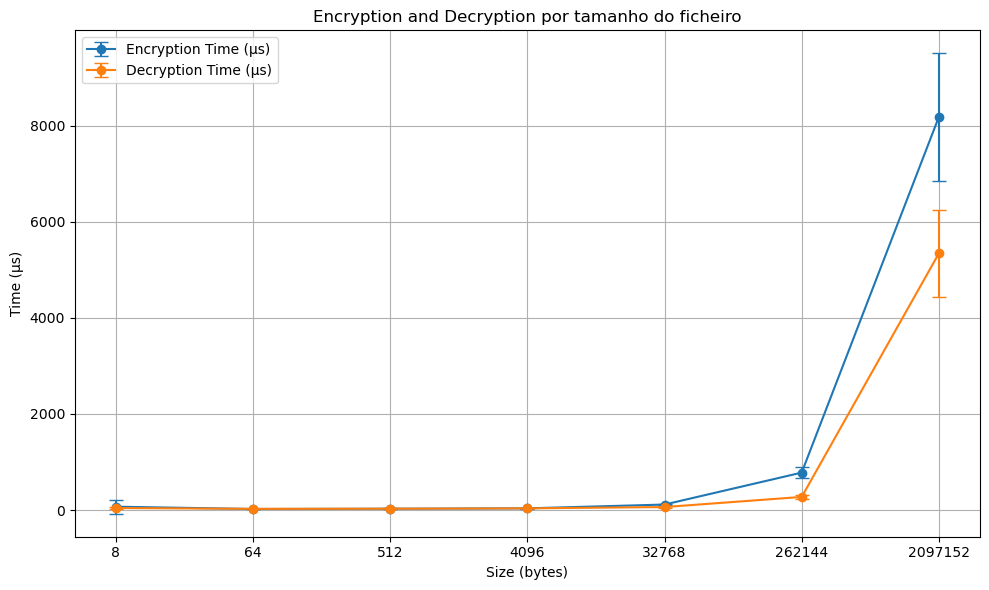

In [35]:
plt.figure(figsize=(10, 6))

mean_enc = [x * 1e6 for x in tempos_enc_AES]
mean_dec = [x * 1e6 for x in tempos_dec_AES]
std_enc = [x * 1e6 for x in stds_enc_AES]
std_dec = [x * 1e6 for x in stds_dec_AES]

tamanho=range(len(tamanhosAES))

plt.errorbar(tamanho, mean_enc, yerr=std_enc, fmt='-o', label='Encryption Time (µs)', capsize=5)
plt.errorbar(tamanho, mean_dec, yerr=std_dec, fmt='-o', label='Decryption Time (µs)', capsize=5)

plt.xticks(tamanho, tamanhosAES)
plt.xlabel('Size (bytes)')
plt.ylabel('Time (µs)')
plt.title('Encryption and Decryption por tamanho do ficheiro')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### C. Encrypting and decrypting with RSA

In [39]:
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import rsa, padding

In [40]:
private_key = rsa.generate_private_key(public_exponent=65537,key_size=2048,backend=default_backend())
public_key =private_key.public_key()

def encrypt_RSA(original):
    start=time.perf_counter()
    encrypted = public_key.encrypt(
        original, 
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),
            algorithm=hashes.SHA256(),
            label=None
        )
    )
    end=time.perf_counter()
    return encrypted, end-start

def decrypt_RSA(encrypted):
    start = time.perf_counter()
    decrypted = private_key.decrypt(
        encrypted, 
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),
            algorithm=hashes.SHA256(),
            label=None
        )
    )
    end = time.perf_counter()
    return decrypted, end-start

resultados_RSA = []
reps = 100

for t in tamanhosRSA:
    with open(f"Ficheiros/RSA_{t}.txt","rb") as file:
        original = file.read()

    tempo_enc = 0
    tempo_dec = 0
    
    for i in range(reps):
        encrypted,tempo = encrypt_RSA(original)
        tempo_enc += tempo

        
        original,tempo = decrypt_RSA(encrypted)
        tempo_dec += tempo

    tempo_enc /= reps
    tempo_dec /= reps

    tempo_enc *= 1e6 #converte para microsegundos
    tempo_dec *= 1e6

    resultados_RSA.append((t, tempo_enc, tempo_dec))

    print(t, "bytes: ")
    print(f"encryption time:{tempo_enc: .2f} microssegundos")
    print(f"decryption time:{tempo_dec: .2f} microssegundos")
    print("")

8 bytes: 
encryption time: 91.11 microssegundos
decryption time: 1101.32 microssegundos

64 bytes: 
encryption time: 94.35 microssegundos
decryption time: 1191.80 microssegundos



ValueError: Encryption failed

#### C.1. Comparing RSA results

### D. Encryption and Decryption with SHA-256

In [ ]:
def hashing_SHA(original):
    digest = hashes.Hash(hashes.SHA256(), backend=default_backend())
    digest.update(original)

    return digest.finalize()

hash_generation = []

for t in tamanhosSHA:
    with open(f"Ficheiros/SHA_{t}.txt","rb") as file:
        original = file.read()

    tempo_hash = 0
    
    for i in range(reps):
        start = timeit.default_timer()
        hashing_SHA(original)
        end = timeit.default_timer()
        tempo_hash += end - start

    tempo_hash /= reps

    tempo_hash *= 1e6 #converte para microsegundos

    hash_generation.append(tempo_hash)

    print(t , "bytes:")
    print(f"hash generation time:{tempo_hash: .2f} microssegundos")
    print("")

2 bytes:
hash generation time: 42.11 microssegundos

4 bytes:
hash generation time: 49.45 microssegundos

8 bytes:
hash generation time: 27.29 microssegundos

16 bytes:
hash generation time: 18.00 microssegundos

32 bytes:
hash generation time: 17.41 microssegundos

64 bytes:
hash generation time: 20.85 microssegundos

128 bytes:
hash generation time: 17.98 microssegundos



### E. Result Comparison